In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import random

In [2]:
EON="EON"

In [3]:
# Reading datafile

with open('babiesLarge.txt') as f:
    data = f.read()

Number of names are: 2000
Maximum length of names: 11


(array([  2.,  54., 244., 481., 610., 376., 159.,  62.,  10.,   2.]),
 array([ 2. ,  2.9,  3.8,  4.7,  5.6,  6.5,  7.4,  8.3,  9.2, 10.1, 11. ]),
 <a list of 10 Patch objects>)

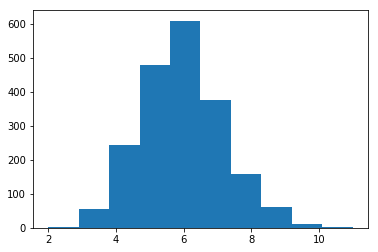

In [4]:
# Getting anmes as list in lowercase

names = data.split("\n")[:-1]
names = [x.lower() for x in names]
name_len = [len(x) for x in names]
max_name_len = max(name_len)
print('Number of names are: {}'.format(len(names)))
print('Maximum length of names: {}'.format(max_name_len))
plt.hist(name_len)

In [5]:
unique_tokens = []
for x in names:
    unique_tokens+=list(x)
unique_tokens = list(set(unique_tokens))
unique_tokens.append(EON)
len_unique_tokens = len(unique_tokens)
print("Number of unique tokens: {}".format(len_unique_tokens))

Number of unique tokens: 27


In [6]:
token_to_idx = {}
idx_to_token = {}
for x,y in enumerate(unique_tokens):
    token_to_idx[y]=x
    idx_to_token[x]=y

In [7]:
def input_tensor(name,max_name_len,len_unique_tokens,token_to_idx):
    if len(name)==11:
        name_len = 10
    else: name_len=len(name)
    vector = torch.zeros(1,max_name_len-1,len_unique_tokens)
    for x in range(name_len):
        character = name[x]
        vector[0,x,token_to_idx[character]]=1
    for x in range(name_len,max_name_len-1):
        character='EON'
        vector[0,x,token_to_idx[character]]=1
    return vector

def output_tensor(name,max_name_len,token_to_idx):
    vector = [token_to_idx[x] for x in name[1:]]
    vector+=[token_to_idx['EON']]*(max_name_len-len(name))
    #print([vector])
    return torch.LongTensor([vector])

In [8]:
input_names = torch.tensor([])
out_names = torch.LongTensor([])
for x in names:
    input_names = torch.cat((input_names,input_tensor(x,max_name_len,len_unique_tokens,token_to_idx)),0)
    out_names = torch.cat((out_names,output_tensor(x,max_name_len,token_to_idx)),0)
print("Input shape is : {}".format(input_names.size()))
print("Output shape is : {}".format(out_names.size()))

Input shape is : torch.Size([2000, 10, 27])
Output shape is : torch.Size([2000, 10])


In [9]:
class RNNModel(nn.Module):
    
    def __init__(self, device, input_size, output_size, hidden_dim, n_layers):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        self.fc = nn.Linear(hidden_dim, output_size)
        self.device = device
    def forward(self, x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(self.device)
        return hidden

In [10]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [11]:
model = RNNModel(device=device, input_size=len_unique_tokens, output_size=len_unique_tokens,  hidden_dim=50, n_layers=5)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 1000
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

if(torch.cuda.is_available()):
    model.cuda()
    input_names = input_names.cuda() 
    out_names = out_names.cuda()

In [12]:
input_names.size()

torch.Size([2000, 10, 27])

In [13]:
# Training Run
loss_list = []
iteration_list = []
input_names = input_names.to(device)
count=0
for epoch in range(1, n_epochs + 1):
    count+=1
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(input_names)
    output = output.to(device)
    out_names = out_names.to(device)
    loss = criterion(output, out_names.view(-1).long())
    loss_list.append(loss.data)
    iteration_list.append(count)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 100/1000............. Loss: 1.4513
Epoch: 200/1000............. Loss: 1.2068
Epoch: 300/1000............. Loss: 1.0535
Epoch: 400/1000............. Loss: 0.8625
Epoch: 500/1000............. Loss: 0.7221
Epoch: 600/1000............. Loss: 0.6362
Epoch: 700/1000............. Loss: 0.5894
Epoch: 800/1000............. Loss: 0.5849
Epoch: 900/1000............. Loss: 0.5332
Epoch: 1000/1000............. Loss: 0.5153


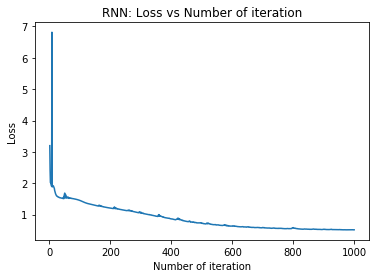

In [14]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

In [164]:
def predict(model, name):
    # One-hot encoding our input to fit into the model
    vector = torch.zeros(1,len(name),len_unique_tokens)
    for x in range(len(name)):
        character = name[x]
        vector[0,x,token_to_idx[character]]=1
    vector = vector.to(device)
    
    out, hidden = model(vector)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    #char_ind = torch.max(prob, dim=0)[1].item()
    
    # Taking the class with the 3 highest probability score from the output
    prob = torch.topk(prob,3)[1].tolist()
    
    if random.random()<0.45:
        char_ind = prob[0]
    elif random.random()>=0.45 and random.random()>=0.80:
        char_ind = prob[1]
    else:
        char_ind = prob[2]

    return idx_to_token[char_ind], hidden

In [165]:
def sample(model, out_len, start):
    model.eval() # eval mode
    start = start.lower()
    # Now pass in the previous characters and get a new one
    for ii in range(out_len):
        char, h = predict(model, start)
        if char=='EON':
            break
        else:
            start+=char
    return start

In [168]:
for x in range(20):
    print(sample(model, max_name_len, 'a'))

armuly
ariye
alaia
armahla
alex
aryeser
arian
ariyemo
alaiza
alayahsamire
alanima
aryes
alani
arielc
aria
alejardr
aria
ariah
armahlahi
ariyam
